<a href="https://colab.research.google.com/github/Swadesh13/Neural-Style-Transfer/blob/master/Art_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**To Generate a new stylised image by combining 2 images, one the content image and other the style image**

Content Image: C

Style Image: S

Generated Image: G

Formulae and Code have mostly been taken from Coursera course on Deep Learning Specialization and the Tensorflow documentary 

In [0]:
## Required Libraries ##

import IPython.display as display
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.linalg import einsum
import imageio

%matplotlib inline

In [2]:
## Checking Connection to GPU ##

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Define all the hyperparameters

In [0]:
image_height = 600
image_width = 800
weights = 'imagenet' 
channels = 3 # RGB image : 3, B&W : 1 
content_image_path = '/content/Nature.bmp'
style_image_path = '/content/Design.bmp'
content_weight = 1e5
style_weight = 1e-2
opt = Adam(learning_rate=0.05, beta_1=0.99, epsilon=1e-1)
iterations = 100
total_variation_weight = 1e2
style_layers_weights = {
                'block1_conv1' : 1, 
                'block2_conv1' : 1,
                'block3_conv1' : 1, 
                'block4_conv1' : 1,
                'block5_conv1' : 1
                }
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

**Computing the content cost, J(C, G) for some hidden layer l**

>$J_{content}(C,G)= \frac{1}{4×n_H×n_W×n_C} ∑_{all entries} (a^{(C)}−a^{(G)})^2$

where,

$n_H$, $n_W$ and $n_C$ are the height, width and number of channels of the hidden layer

$a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations

In [0]:
def content_cost(outputs, targets):
    """
    Computes the content cost

    Arguments:
    outputs -- dict containing the outputs for the generated image from the required layers
    targets -- dict containing the outputs for the content image from the same layers

    Returns:
    J_content -- scalar quantity denoting the mean squared loss of the output from the target
    """

    J_content = tf.add_n([tf.reduce_mean((outputs[name] - targets[name])**2) for name in outputs.keys()])

    return J_content

**Computing the content cost, J(C, G) for some hidden layer l**


**Gram Matrix**

The style of an image can be described by the means and correlations across the different feature maps. A Gram matrix includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer as:

>$G_{cd}^l=\frac{\sum_{ij}F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$


In [0]:
def gram_matrix(input_tensor):
    """
    Calculates the gram natrix

    Arguments:
    input_tensor -- Tensor for which the gram natrix needs to be calculated

    Returns:
    Gram matrix 
    """
    
    result = einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result/(num_locations)

**Style Cost**

>$J^{[l]}_{style}(S,G)=\frac{1}{4×n_C^2×(n_H×n_W)^2}∑_{i=1}^{n_C}∑_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} − G^{(G)}_{(gram)i,j})^2$

$G^{(S)}_{gram}$ : Gram matrix of the "style" image.

$G^{(G)}_{gram}$ :  Gram matrix of the "generated" image.

**Style Weights**

We'll get better results if we "merge" style costs from several different layers.

Each layer will be given weights ( $λ^{[l]}$ ) that reflect how much each layer will contribute to the style.

We can combine the style costs for different layers as follows:

>$J_{style}(S,G)=∑_lλ^{[l]}J^{[l]}_{style}(S,G)$
 
where the values for  $λ^{[l]}$  are given in style_layers_weights.

In [0]:
def style_cost(outputs, targets, style_layers):
    """
    Computes the style cost

    Arguments:
    outputs -- dict containing the outputs for the generated image from the required layers
    targets -- dict containing the outputs for the style image from the same layers 

    Returns:
    J_content -- scalar quantity denoting the mean squared loss of the output from the target
    """

    J_style = tf.add_n([style_layers[name] * tf.reduce_mean((outputs[name] - targets[name])**2) for name in outputs.keys()])

    return J_style

**Total Cost**

>$J(G)=αJ_{content}(C,G)+βJ_{style}(S,G)$

In [0]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = content_weight, beta = style_weight):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

**Calculations of the loss from the outputs**

In [0]:
def style_content_loss(outputs):
    """
    Uses the functions defined above to find the total loss from the outputs of the various layers for different images
    
    Arguments:
    outputs -- Outputs of the style and content layers for the generated image

    Returns:
    loss -- Total loss
    """

    style_outputs = outputs['style']
    content_outputs = outputs['content']

    content_loss = content_cost(content_outputs, content_targets)
    style_loss = style_cost(style_outputs, style_targets, style_layers_weights)

    loss = total_cost(content_loss, style_loss)

    return loss

**Save the images**

In [0]:
def save_image(image, path = 'stylized-image.png'):
    """
    Save Image
    """
    tensor_to_image(image).save(path)

**Load Image**

In [0]:
def load_img(path_to_img):
    """
    Load image from path
    """
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    img = tf.image.resize(img, (image_height, image_width))
    
    return img

**Display Image by converting tensor to image**

In [0]:
def tensor_to_image(tensor):
    """
    Converts a float(0,1) tensor to image with 0-255 pixel values
    """
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return Image.fromarray(tensor)

**Keep the pixel values of image in between 0 and 1** 

In [0]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

**Using tf.Gradient to update image**

In [0]:
with tf.device('/device:GPU:0'):
    def train_step(image):
        """
        Function from where model is iterated with the generated image to calculate the loss
        """
        with tf.GradientTape() as tape:
          outputs = extractor(image)
          loss = style_content_loss(outputs)
          loss += total_variation_weight*tf.image.total_variation(image)

        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

**Content Image**


TensorShape([1, 600, 800, 3])

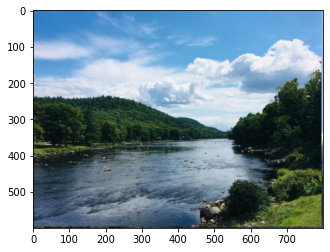

In [16]:
content_image = load_img(content_image_path)
imshow(content_image[0])
content_image.shape

**Style Image**

TensorShape([1, 600, 800, 3])

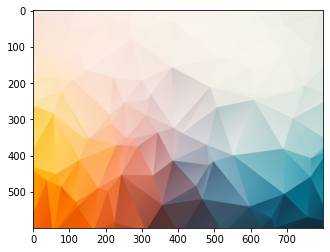

In [17]:
style_image = load_img(style_image_path)
style_image = tf.image.resize(style_image, (image_height, image_width))
imshow(style_image[0])
style_image.shape

Transfer Learning the VGG-19 Model

In [0]:
def vgg_layers(layer_names):
    """
    Using the VGG-19 model to process the image
    """
    vgg = VGG19(include_top = False, weights = weights)
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = Model([vgg.input], outputs)

    return model

**Extract Style and Content**

In [0]:
with tf.device('/device:GPU:0'):    
    class StyleContentModel(Model):
      """
      returns the content outputs and the gram matrix from the style outputs from the layers  
      """
      def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

      def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

**Initializing the class**

In [0]:
extractor = StyleContentModel(style_layers, content_layers)

**Output of the layers for the content and the style image**

In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [0]:
image = tf.Variable(content_image)

In [0]:
for i in range (iterations*5):
    train_step(image)
    if(i%20==0):
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))

In [0]:
imshow(image[0])

In [0]:
save_image(image)

**Load the Neural Style Transfer model from tensorflow and try it**

In [0]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)